# Exploration du Dataset MAESTRO

In [1]:
# Imports
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter

# Configuration matplotlib
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

## 1) Chargement des Métadonnées

Le fichier maestro-v3.0.0.json contient toutes les métadonnées : compositeur, titre, durée, split (train/val/test), etc.

In [2]:
# Définition des chemins des fichiers MIDI et des métadonnées

MAESTRO_DIR = Path("../data/maestro/maestro-v3.0.0")
JSON_PATH = MAESTRO_DIR / "maestro-v3.0.0.json"

In [7]:
# On charge les métadonnées
with open(JSON_PATH, 'r') as f:
    metadata = json.load(f)

# On converti en dataframe
df = pd.DataFrame(metadata)

print(f"Nombre total d'enregistrements: {len(df)}")
print("Colonnes disponibles:")
for col in df.columns:
    print(f"- {col}")

Nombre total d'enregistrements: 1276
Colonnes disponibles:
- canonical_composer
- canonical_title
- split
- year
- midi_filename
- audio_filename
- duration


In [12]:
# Aperçu des données
df.head(2)

,canonical_composer,canonical_title,split,year,midi_filename,audio_filename,duration
0,Alban Berg,Sonata Op. 1,train,2018,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,698.661160
1,Alban Berg,Sonata Op. 1,train,2008,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,759.518471


## 2) Analyse statistique du dataset

Répartition par split :
train        :  962 fichiers (75.39%)
test         :  177 fichiers (13.87%)
validation   :  137 fichiers (10.74%)


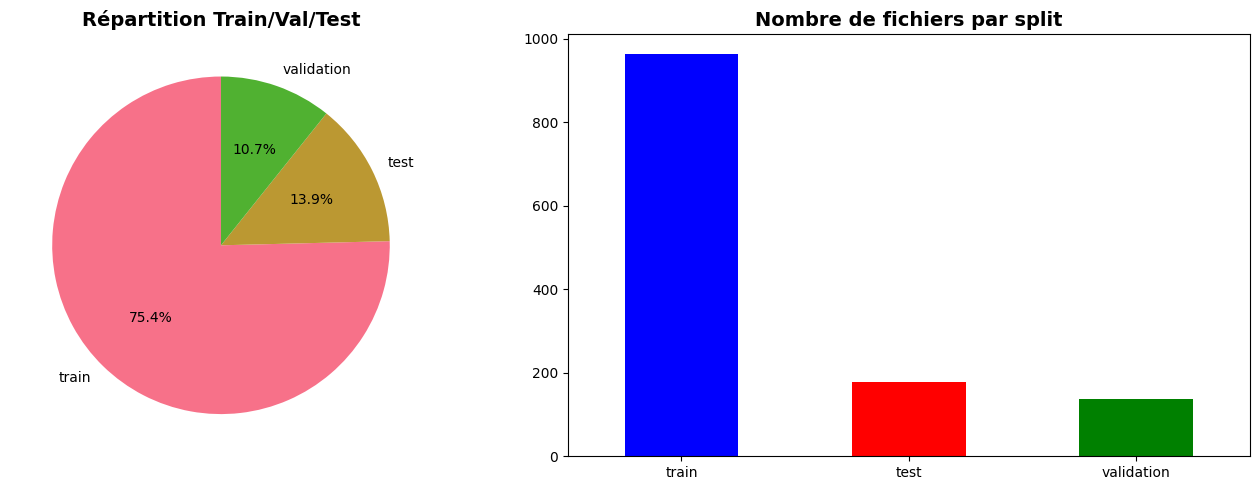

In [65]:
print("Répartition par split :")
split_counts = df['split'].value_counts()
for split, count in split_counts.items():
    percentage = (count / len(df)) * 100
    print(f"{split:12s} : {count:4d} fichiers ({percentage:5.2f}%)")

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Visualisation des pourcentages
split_counts.plot(kind='pie', ax=ax[0], autopct='%.1f%%', startangle=90)
ax[0].set_title('Répartition Train/Val/Test', fontsize=14, fontweight='bold')
ax[0].set_ylabel('')

# Visualisation du nombre de fichiers par split
split_counts.plot(kind='bar', ax=ax[1], color=['blue', 'red', 'green'])
ax[1].set_title('Nombre de fichiers par split', fontsize=14, fontweight='bold')
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

In [53]:
# Analyse des compositeurs
composer_counts = df['canonical_composer'].value_counts()
print(f"Nb total de compositeurs : {len(composer_counts)}")
print(f"Les 10 premiers compositeurs ayant le + de compo :")
for composer, count in composer_counts.head(5).items():
    print(f"{composer:22s}: {count:3d} fichiers MIDI")

print(f"\nLes 10 derniers :")
for composer, count in composer_counts.tail(5).items():
    print(f"{composer:46s}: {count:3d} fichiers MIDI")

Nb total de compositeurs : 60
Les 10 premiers compositeurs ayant le + de compo :
Frédéric Chopin       : 201 fichiers MIDI
Franz Schubert        : 186 fichiers MIDI
Ludwig van Beethoven  : 146 fichiers MIDI
Johann Sebastian Bach : 145 fichiers MIDI
Franz Liszt           : 131 fichiers MIDI

Les 10 derniers :
Nikolai Rimsky-Korsakov / Sergei Rachmaninoff :   1 fichiers MIDI
Orlando Gibbons                               :   1 fichiers MIDI
Robert Schumann / Franz Liszt                 :   1 fichiers MIDI
Sergei Rachmaninoff / György Cziffra          :   1 fichiers MIDI
Sergei Rachmaninoff / Vyacheslav Gryaznov     :   1 fichiers MIDI


In [56]:
# Analyse de la durée

print("Durée des enregistrements:")
print(f"Durée totale  : {df['duration'].sum() / 3600:.1f} heures")
print(f"Durée moyenne : {df['duration'].mean() / 60:.1f} minutes")
print(f"Durée médiane : {df['duration'].median() / 60:.1f} minutes")
print(f"Durée min     : {df['duration'].min() / 60:.1f} minutes")
print(f"Durée max     : {df['duration'].max() / 60:.1f} minutes")

Durée des enregistrements:
Durée totale  : 198.7 heures
Durée moyenne : 9.3 minutes
Durée médiane : 7.2 minutes
Durée min     : 0.8 minutes
Durée max     : 43.7 minutes


C:\Users\jerem\AppData\Local\Temp\ipykernel_41672\394340437.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0].legend()


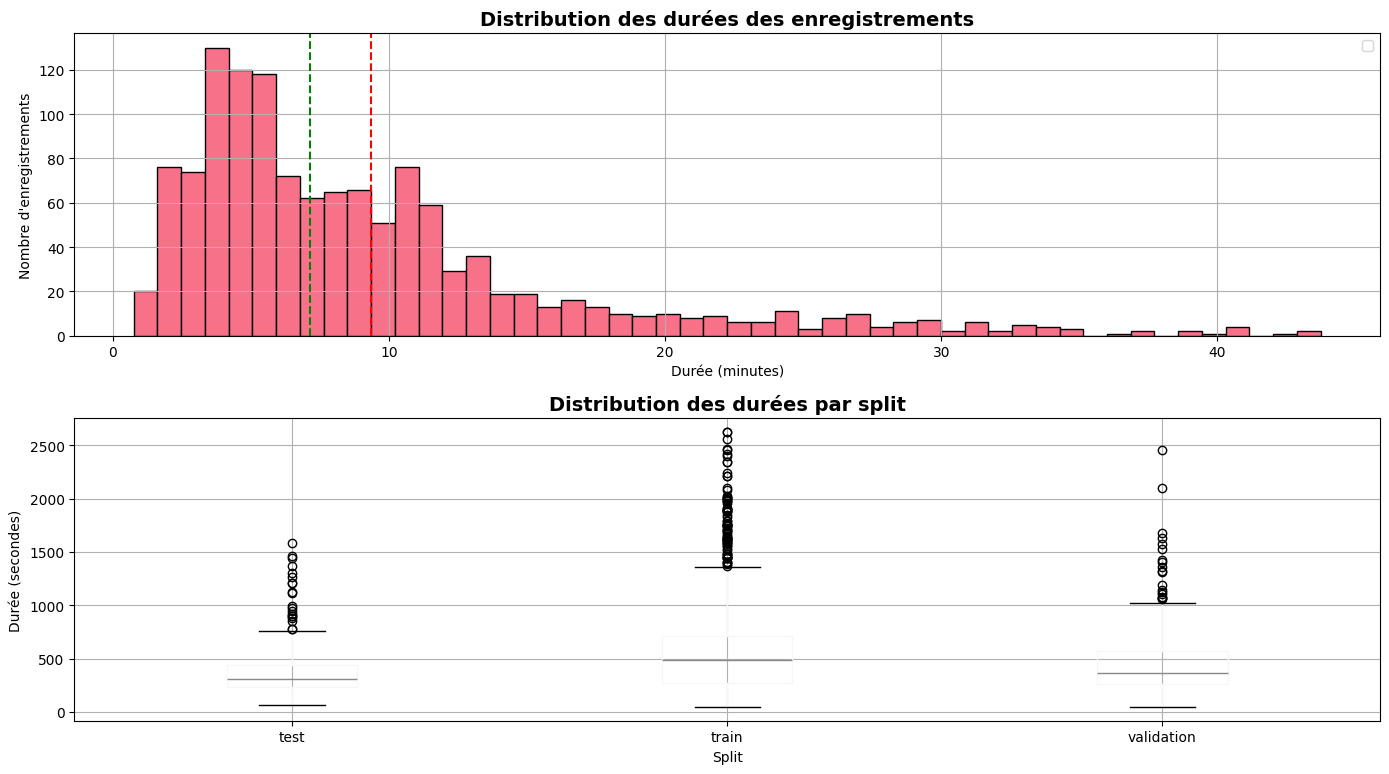

In [67]:
# Visualisation de la distribution des durées
fig, ax = plt.subplots(2, 1, figsize=(14, 8))

# Histogramme
df['duration'].apply(lambda x: x/60).hist(bins=50, ax=ax[0], edgecolor='black')
ax[0].set_title('Distribution des durées des enregistrements', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Durée (minutes)')
ax[0].set_ylabel('Nombre d\'enregistrements')
ax[0].axvline(df['duration'].mean()/60, color='red', linestyle='--')
ax[0].axvline(df['duration'].median()/60, color='green', linestyle='--')
ax[0].legend()

# Boxplot par split
df.boxplot(column='duration', by='split', ax=ax[1])
ax[1].set_title('Distribution des durées par split', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Split')
ax[1].set_ylabel('Durée (secondes)')

plt.suptitle('')
plt.tight_layout()
plt.show()

## 3) Exploration d'un Fichier MIDI

In [69]:
from music21 import converter, instrument, note, chord

# On sélectionne un fichier MIDI aléatoire
sample_file = df.sample(1).iloc[0]
midi_path = MAESTRO_DIR / sample_file['midi_filename']

print(f"Fichier sélectionné:")
print(f"Titre       : {sample_file['canonical_title']}")
print(f"Compositeur : {sample_file['canonical_composer']}")
print(f"Année       : {sample_file['year']}")
print(f"Durée       : {sample_file['duration'] / 60:.1f} minutes")
print(f"Chemin      : {sample_file['midi_filename']}")

Fichier sélectionné:
Titre       : Sonata in C Minor, First Movement
Compositeur : Joseph Haydn
Année       : 2008
Durée       : 5.0 minutes
Chemin      : 2008/MIDI-Unprocessed_12_R1_2008_01-04_ORIG_MID--AUDIO_12_R1_2008_wav--1.midi


In [75]:
# On le charge avec Music21
score = converter.parse(midi_path)

print(f"Informations sur le fichier :")
print(f"Nombre de parties : {len(score.parts)}")
print(f"Durée en temps (noires) : {score.duration.quarterLength} temps") # Le temps est la durée en nombre de noires

# On regarde le nombre de parties
for i, part in enumerate(score.parts):
    print(f"Partie {i+1}:")

    # Notes et accords
    notes = part.flat.notesAndRests
    print(f"Nombre d'événements notes + silences : {len(notes)}")
    
    # Compter notes vs silences
    note_count = len([n for n in notes if isinstance(n, (note.Note, chord.Chord))])
    rest_count = len(notes) - note_count
    print(f"Notes/Accords: {note_count}")
    print(f"Silences: {rest_count}")

Informations sur le fichier :
Nombre de parties : 1
Durée en temps (noires) : 629.0 temps
Partie 1:
Nombre d'événements notes + silences : 2422
Notes/Accords: 1471
Silences: 951


In [76]:
# On extrait toutes les notes pour les analyser
all_notes = []
all_velocities = []
all_durations = []

for element in score.flat.notesAndRests:
    if isinstance(element, note.Note): # Notes
        all_notes.append(element.pitch.midi)
        all_velocities.append(element.volume.velocity)
        all_durations.append(float(element.duration.quarterLength))
    elif isinstance(element, chord.Chord): # Accords
        # Pour les accords, prendre la note la plus haute
        all_notes.append(max([p.midi for p in element.pitches]))
        all_velocities.append(element.volume.velocity)
        all_durations.append(float(element.duration.quarterLength))

print(f"Caractéristiques extraites:")
print(f"Nombre total de notes : {len(all_notes)}")
print(f"Note MIDI min         : {min(all_notes)} ({note.Note(midi=min(all_notes)).nameWithOctave})")
print(f"Note MIDI max         : {max(all_notes)} ({note.Note(midi=max(all_notes)).nameWithOctave})")
print(f"Vélocité moyenne      : {sum(all_velocities)/len(all_velocities):.1f}")

Caractéristiques extraites:
Nombre total de notes : 1471
Note MIDI min         : 31 (G1)
Note MIDI max         : 89 (F6)
Vélocité moyenne      : 61.4


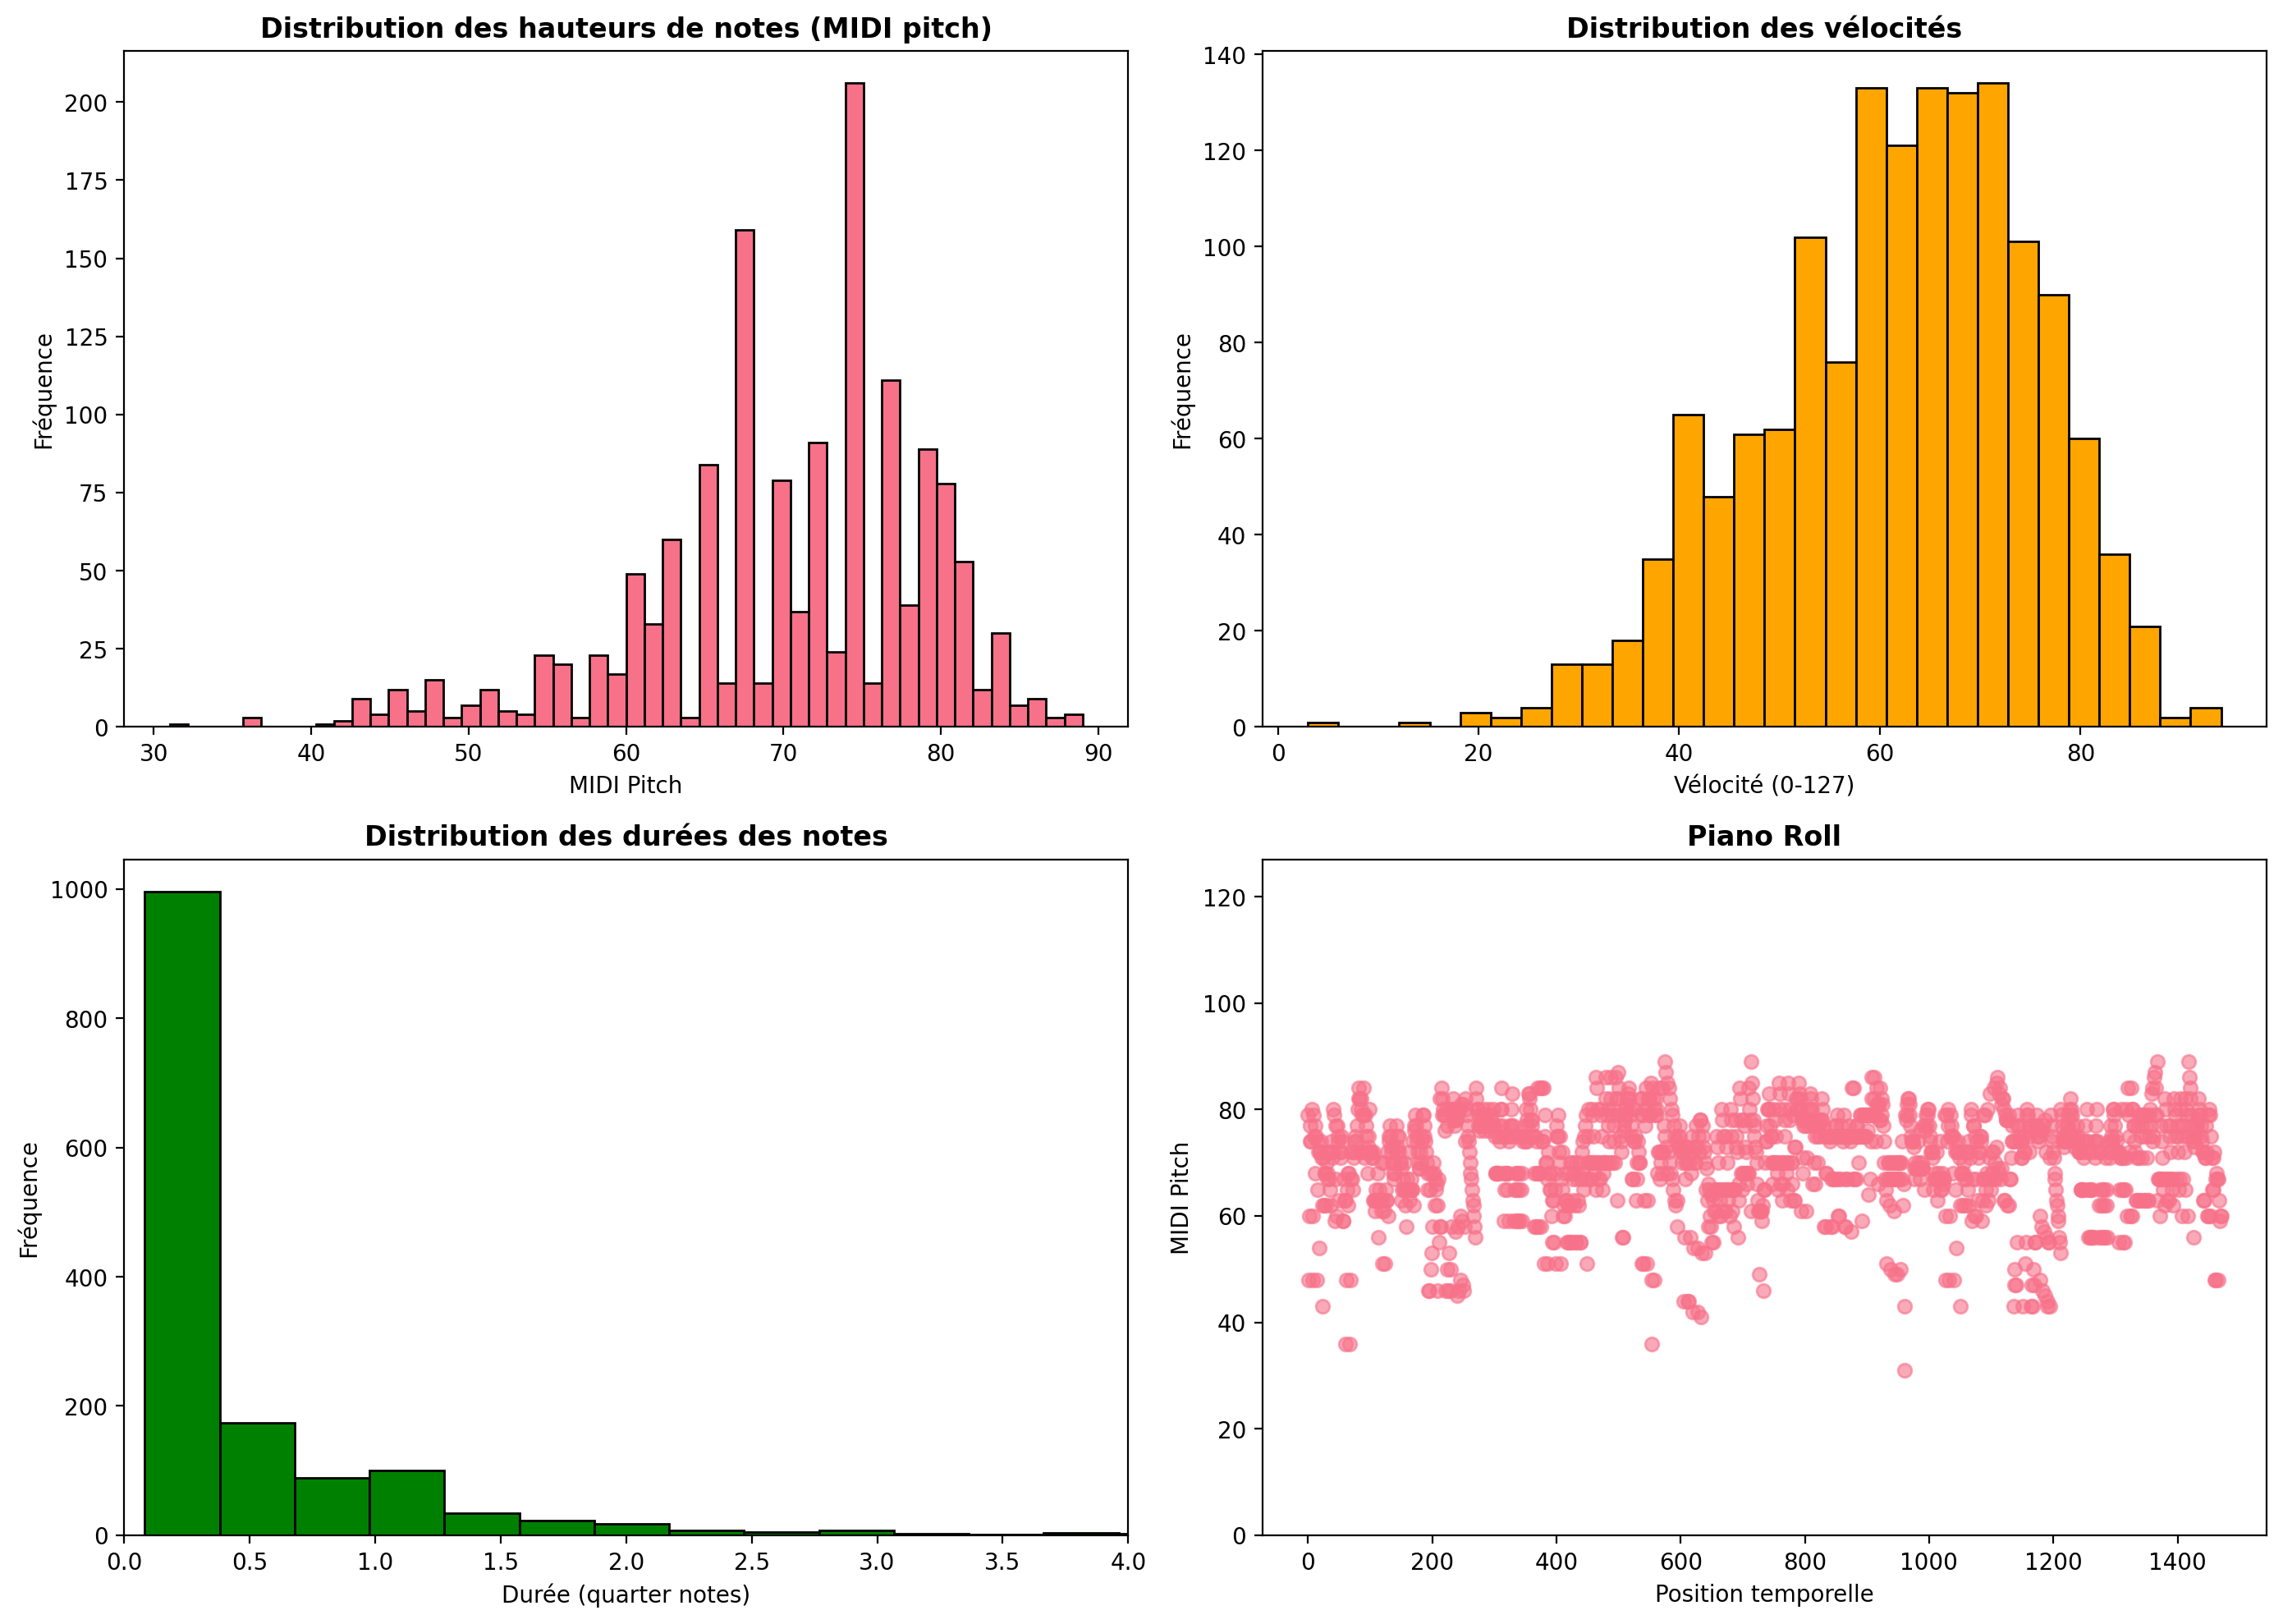

In [80]:
# Visualisation des caractéristiques du MIDI
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Distribution des hauteurs (pitches)
ax[0, 0].hist(all_notes, bins=50, edgecolor='black')
ax[0, 0].set_title('Distribution des hauteurs de notes (MIDI pitch)', fontweight='bold')
ax[0, 0].set_xlabel('MIDI Pitch')
ax[0, 0].set_ylabel('Fréquence')

# Distribution des vélocités
ax[0, 1].hist([v for v in all_velocities if v is not None], bins=30, edgecolor='black', color='orange')
ax[0, 1].set_title('Distribution des vélocités', fontweight='bold')
ax[0, 1].set_xlabel('Vélocité (0-127)')
ax[0, 1].set_ylabel('Fréquence')

# Distribution des durées
ax[1, 0].hist(all_durations, bins=50, edgecolor='black', color='green')
ax[1, 0].set_title('Distribution des durées des notes', fontweight='bold')
ax[1, 0].set_xlabel('Durée (quarter notes)')
ax[1, 0].set_ylabel('Fréquence')
ax[1, 0].set_xlim(0, 4)

# Piano roll (les n événements)
sample_notes = all_notes[:2422] # Modifier n en fonction du nb d'évènements
ax[1, 1].scatter(range(len(sample_notes)), sample_notes, alpha=0.6)
ax[1, 1].set_title('Piano Roll', fontweight='bold')
ax[1, 1].set_xlabel('Position temporelle')
ax[1, 1].set_ylabel('MIDI Pitch')
ax[1, 1].set_ylim(0, 127)

plt.tight_layout()
plt.show()

## 5. Conclusions pour le Preprocessing

In [83]:
# Conclusion du dataset pour le preprocessing
stats = {
    'total_files': len(df),
    'total_duration_hours': df['duration'].sum() / 3600,
    'mean_duration_minutes': df['duration'].mean() / 60,
    'num_composers': len(composer_counts),
    'train_files': len(df[df['split'] == 'train']),
    'val_files': len(df[df['split'] == 'validation']),
    'test_files': len(df[df['split'] == 'test'])
}

print("Résumé des statistiques:")
for key, value in stats.items():
    print(f"   {key:25s}: {value:.2f}" if isinstance(value, float) else f"   {key:25s}: {value}")

Résumé des statistiques:
   total_files              : 1276
   total_duration_hours     : 198.65
   mean_duration_minutes    : 9.34
   num_composers            : 60
   train_files              : 962
   val_files                : 137
   test_files               : 177
